In [1]:
%reload_ext autoreload
%autoreload 2

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.models import MLP, CNN2P2, AlexNet
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import datasets

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [2]:
def gray_to_rgb(x):
    return x.repeat(1, 3, 1, 1)

preprocess = transforms.Compose([
            transforms.ToTensor(), # first, convert image to PyTorch tensor
            transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
            # transforms.Resize((224, 224)),
            # transforms.Lambda(torch.flatten), # convert to vectors
        ])
trainloader, testloader = datasets.downloadMNIST(batchSize=1024, preprocess=preprocess)

In [3]:
# net = MLP()
net = CNN2P2()
# net = AlexNet()
net.to(DEVICE)
    
# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
# optimizer = torch.optim.Adadelta(net.parameters())
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Preallocate summary variables  
iterations = 1
numTrainingSteps = len(trainloader)*iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
alignFull = []
deltaWeights = []

init_weights = net.get_alignment_weights()

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    print('iteration: ', epoch)
    
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0

    for idx,batch in tqdm(enumerate(trainloader)):
        cidx = epoch*len(trainloader) + idx
        
        images, label = batch
        # images = gray_to_rgb(images)
        images = images.to(DEVICE)
        label = label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images, store_hidden=True)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]

        # Measure Integration
        alignFull.append(net.measure_alignment(images, precomputed=True, method='alignment'))
        
        # Measure Change in Weights
        deltaWeights.append(net.compare_weights(init_weights))

    # Print statistics for each epoch
    print('Loss in epoch %3d: %.3f, Accuracy: %.2f%%.' % (epoch, loss.item(), 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]))


iteration:  0


59it [00:09,  6.52it/s]

Loss in epoch   0: 0.762, Accuracy: 74.51%.


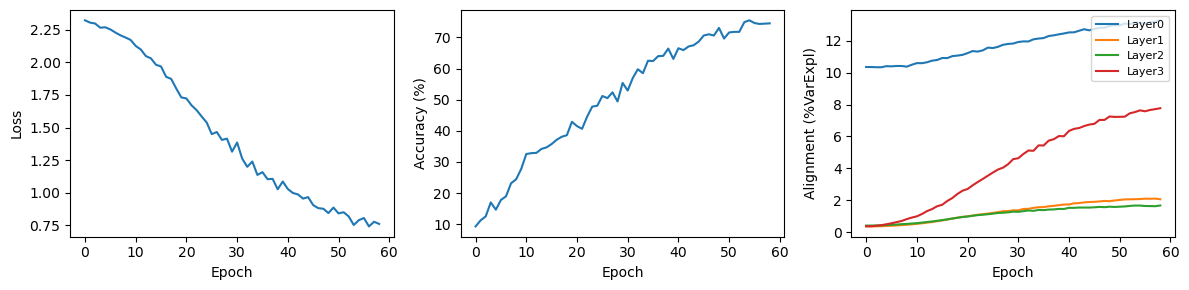

In [4]:
# This code plots absolute values of loss, accuracy, similarity, and integration
# -- useful for knowing what the true (unnormalized) values are --
numEpoch = trackLoss.shape[0]
alignMean = utils.avg_from_full(alignFull)

# Note: similarity and integration are only current -- I changed it to simMean,intMean,simStd,intStd for future reference and for plotting error bars!
fig,ax = plt.subplots(1,3,figsize=(12,3))
ax[0].plot(trackLoss)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(trackAccuracy)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
for i in range(alignMean.shape[0]):
    ax[2].plot(alignMean[i,:]*100,label=f'Layer{i}')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Alignment (%VarExpl)')
ax[2].legend(fontsize=8, loc='upper right')

plt.tight_layout()

In [5]:
# TODO
# 1.1. include additional AlignmentModel methods stored in extra class in base model
# -- the measure_eigenfeature method is baaaaad -- because it doesn't account for convolutional layers
# -- I should consider weighing the each_stride average by the average norm of the input in that stride...
# 2. Make datasets a class
# 3. Make training a nice method
# 4. Rewrite existing analysis pipelines
# 5. SLURM!!!!

In [6]:
fraction_dropout = 0.33
align_per_node = [torch.nanmean(af.view(af.size(0), -1), dim=1) for af in alignFull[-1]]
idx_alignment = [torch.argsort(-align) for align in align_per_node]
idx_align_high = [idx[:int(len(idx)*fraction_dropout)] for idx in idx_alignment]
idx_align_low = [idx[-int(len(idx)*fraction_dropout):] for idx in idx_alignment]
out_no_low, _ = net.forward_targeted_dropout(images, idx_align_low[:-1], range(len(idx_align_low)-1))
out_no_high, _ = net.forward_targeted_dropout(images, idx_align_high[:-1], range(len(idx_align_high)-1))
out = net(images)

loss_no_low = loss_function(out_no_low, label).item()
loss_no_high = loss_function(out_no_high, label).item()
loss_full = loss_function(out, label).item()

acc_no_low = 100*torch.sum(torch.argmax(out_no_low, dim=1)==label)/images.size(0)
acc_no_high = 100*torch.sum(torch.argmax(out_no_high, dim=1)==label)/images.size(0)
acc_full = 100*torch.sum(torch.argmax(out, dim=1)==label)/images.size(0)

print(loss_full, loss_no_low, loss_no_high)
print(acc_full, acc_no_low, acc_no_high)

0.7560245990753174 1.387739658355713 1.9072391986846924
tensor(75.9868, device='cuda:0') tensor(66.7763, device='cuda:0') tensor(57.4013, device='cuda:0')


In [7]:
# beta, evals, evecs = net.measure_eigenfeatures(testloader)

In [8]:
dataloader = testloader

# Measure Activations (without dropout) for all images
training_mode = net.training # save for resetting at the end

# turn off dropout and any training related features
net.eval()

# store input and measure activations for every element in dataloader
allinputs = []
activations = []
dataloop = tqdm(dataloader) if True else dataloader
for input, label in dataloop:    
    allinputs.append(input)
    input = input.to(DEVICE)
    label = label.to(DEVICE)
    activations.append(net.get_activations(x=input, precomputed=False))

# return network to original training mode
if training_mode: 
    net.train()
else:
    net.eval()

100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


In [9]:

# create large list of tensors containing input to each layer
num_layers = len(activations[0])
inputs_to_layers = []
inputs_to_layers.append(torch.cat(allinputs,dim=0).detach().cpu())
for layer in range(num_layers-1):
    inputs_to_layers.append(torch.cat([act[layer] for act in activations],dim=0).detach().cpu())


In [10]:
# retrieve weights and flatten inputs if required
weights = []
zipped = zip(inputs_to_layers, net.get_alignment_layers(), net.get_alignment_metaparameters())
for ii, (input, layer, metaprms) in enumerate(zipped):
    weight = layer.weight.data
    if metaprms['unfold']:
        # unfold weights and add them to weights list
        num_strides = np.prod(utils.get_maximum_strides(input.shape[2], input.shape[3], layer))
        unfolded_weights = weight.view(weight.size(0), -1).repeat(1, num_strides)
        weights.append(unfolded_weights)

        # unfold input activity and update inputs_to_layers
        layer_prms = dict(stride=layer.stride, padding=layer.padding, dilation=layer.dilation)
        unfolded_input = torch.nn.functional.unfold(input, layer.kernel_size, **layer_prms)
        unfolded_input = unfolded_input.transpose(1, 2).reshape(input.size(0), -1)
        inputs_to_layers[ii] = unfolded_input
    else:
        # if not unfolding weights, just add them directly
        weights.append(weight)

In [11]:
[input.shape for input in inputs_to_layers]

[torch.Size([10000, 1764]),
 torch.Size([10000, 14112]),
 torch.Size([10000, 256]),
 torch.Size([10000, 256])]

In [22]:
%%time

ii = 0
%time ccov = torch.cov(inputs_to_layers[ii].T)
%time crank = torch.linalg.matrix_rank(ccov)
%time w, v = torch.linalg.eigh(ccov)

CPU times: total: 672 ms
Wall time: 120 ms
CPU times: total: 766 ms
Wall time: 200 ms
CPU times: total: 531 ms
Wall time: 140 ms
CPU times: total: 1.97 s
Wall time: 460 ms


In [24]:
%%time

ii = 0
N, D = inputs_to_layers[ii].shape
cdata = inputs_to_layers[ii] - torch.mean(inputs_to_layers[ii], dim=1, keepdim=True)

if False and N > D:
    # do eigendecomposition
    ccov = torch.cov(cdata.T)
    w,v = torch.linalg.eigh(ccov)
    
else:
    # do svd instead
    _,s,v = torch.linalg.svd(cdata)
    v = v.T
    w = s**2 / N # convert singular values to eigenvalues

CPU times: total: 1.36 s
Wall time: 234 ms


In [9]:
# Measure eigenfeatures of input to each layer
eigenvalues = []
eigenvectors = []
for input in inputs_to_layers:
    # covariance matrix is positive semidefinite, but numerical errors can produce negative eigenvalues
    print(input.shape)
    ccov = torch.cov(input.T)
    crank = torch.linalg.matrix_rank(ccov)
    # w, v = torch.linalg.eigh(ccov)
    # w_idx = torch.argsort(-w)
    # w = w[w_idx]
    # v = v[:,w_idx]

    # # Automatically set eigenvalues to 0 when they are numerical errors!
    # w[crank:] = 0
    # eigenvalues.append(w)
    # eigenvectors.append(v)

# # Measure absolute value of dot product of weights on eigenvectors for each layer
# beta = []
# for evec, weight in zip(eigenvectors, weights):
#     weight = weight / torch.norm(weight,dim=1,keepdim=True)
#     beta.append(torch.abs(weight.cpu() @ evec))
